<a href="https://colab.research.google.com/github/AShipulin/Train-Scheduler-Simulator-SimPy/blob/main/TrainSchedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# График движения поездов

График движения поездов строится с использованием дискретно-событийного имитационного моделирования.

Для построения используется библиотека SimPy.
В библиотеке существую "общие ресурсы" (PriorityResource), что подходит для принципов построения.

SimPy. Discrete event simulation for Python
* https://simpy.readthedocs.io/en/latest/
* https://pypi.org/project/simpy/
* https://gitlab.com/team-simpy/simpy/

## Установка simpy и необходимых библиотк

In [3]:
!pip install -U simpy
import simpy
import pandas as pd
from matplotlib import pyplot as plt

## Орисовываем построенный график движения поездов

In [4]:
# Строим график движения поездов
def gts(data_log, data):

    df = pd.DataFrame(data_log, columns=["train", "s_beg", "s_end", "t_beg", "t_end"])
    ts = pd.DataFrame(data, columns=["train", "s", "t"])


    t = ts[(ts['train'] == 2001)]
    y = t["s"]
    x = t["t"]
    plt.plot(x, y, label='2001')
    plt.legend()

    t = ts[(ts['train'] == 2002)]
    y = t["s"]
    x = t["t"]
    plt.plot(x, y, label='2002')
    plt.legend()

    plt.xlabel('x время')
    plt.ylabel('y станции')
    plt.title("График движения")

#gts(data_log, data)

In [5]:
# Функция сбора логов по ресурсу
def queue_logger(resource, t_step=1):
    while True:
        # Каждый так добавляем
        item = (
            env.now, # Текущее время
            resource.count, # Использованное число ресурсов
            len(resource.queue) # Дина очереди
        )
        queue_log.append(item)
        # len(manager.queue) - длина очери
        # manager.count - число задействованых менеджеров
        yield env.timeout(t_step)

In [6]:
# Функция завершения интервала по рассписанию
# Интервал длиться долше чем операция с поездом,
# поэтому завершаем за его границами
def queue_exec(t_step=1):
    while True:
        for i in range(len(intScr)):
            if (intScr[i][0] == env.now):
                resInt1 = intScr[i][1]
                reqInt1 = intScr[i][2]
                resInt1.release(reqInt1)
        yield env.timeout(t_step)

## Вводные

Полуавтоблокирка - повзовляет отправлять только один поезд на путь перегона
в попутном направлении, при этом должен выполняться интервал попутного следования.

## Станционные интервалы

Однопутный участок из четырех станйий s1,...s4 и трех перегонов p1, p2, p3
оброудованых полуавтоблокировкой*. На встречу одноврменно отправляется два поезда.

### Задача 1. Интервал срещения


Необходимо обспечить выполнение интервала скрщения поездов при встрече поездов.
Время хода поездов по перегонам 10 минут, не учитвается разгон и замедление.
Интервал срещения 1 минута.


В будщем нудно учесть:
- Время на рзгон
- Время на замеделение
- Приоритеты очередности поездов
- Дифиренсацию интервла разных категорий поездов
- Количесто путей на станции для четных / нечетных поездов


```
-> Чет.              Неч. <-

Поеезд 2002 ->  <- Поезд 2001

s0       s1       s2       s3
|--------|--------|--------|
    p0       p1       p2
is00    is10     is20     is30
is01    is11     is21     is31
```

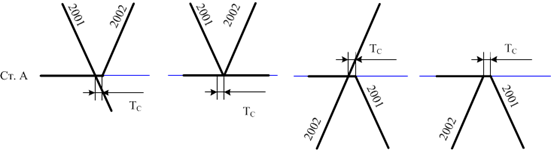

[[2001, 3, 0],
 [2002, 0, 0],
 [2001, 2, 10],
 [2002, 1, 10],
 [2001, 2, 10],
 [2001, 1, 20],
 [2001, 1, 20],
 [2002, 1, 21],
 [2001, 0, 30],
 [2002, 2, 31],
 [2002, 2, 31],
 [2002, 3, 41]]

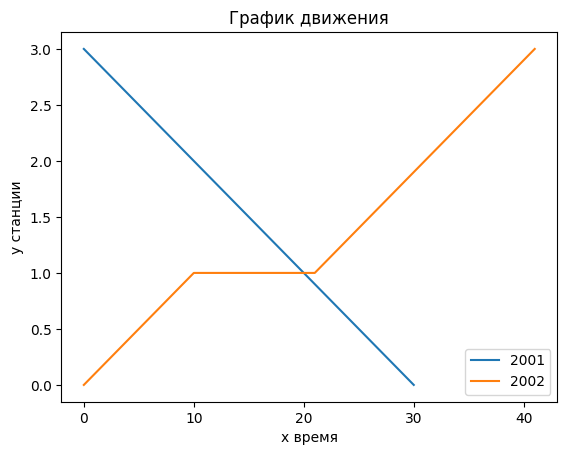

In [10]:
# Списки для сбора метрик
data = []
intScr = []
data_log = []
queue_log = []

# Получаем среду
env = simpy.Environment()

# Станци (не использовал)
s1 = simpy.PriorityResource(env, capacity=5)
s2 = simpy.PriorityResource(env, capacity=3)
s3 = simpy.PriorityResource(env, capacity=3)
s4 = simpy.PriorityResource(env, capacity=5)

# Перегоны
p1 = simpy.PriorityResource(env, capacity=1)
p2 = simpy.PriorityResource(env, capacity=1)
p3 = simpy.PriorityResource(env, capacity=1)

# Интервал скрещения в четном напрвлении
is00 = simpy.PriorityResource(env, capacity=1)
is10 = simpy.PriorityResource(env, capacity=1)
is20 = simpy.PriorityResource(env, capacity=1)
is30 = simpy.PriorityResource(env, capacity=1)

# Интервал скрещения в нечетном напрвлении
is01 = simpy.PriorityResource(env, capacity=1)
is11 = simpy.PriorityResource(env, capacity=1)
is21 = simpy.PriorityResource(env, capacity=1)
is31 = simpy.PriorityResource(env, capacity=1)

resP = [p1, p2, p3]
resI = ([is00, is10, is20, is30],
        [is01, is11, is21, is31])

def operP0(name, env, resP, resI, wait, prio, p):

    s_beg = p
    s_end = p+1
    resPer = resP[p]
    resInt1 = resI[1][s_beg]
    resInt0 = resI[0][s_beg+1]

    # Занимаем интервал
    reqInt0 = resInt0.request(priority=-1)

    # Ждем особождения перегона
    # Ждем осовобождения интервала
    with (resPer.request(priority=prio) as reqPer,
          resInt1.request(priority=prio) as reqInt1):
        yield reqPer & reqInt1

        # Начало занятия перегона
        beg = env.now
        data.append([name, s_beg, env.now])

        # Едем по прегону
        yield env.timeout(10)

        # Конец занятия перегона
        #print(name, s_beg, s_end, beg, env.now)
        data_log.append([name, s_beg, s_end, beg, env.now])
        data.append([name, s_end, env.now])

        # Регестрируем время особождения интервала
        intScr.append([env.now+1, resInt0, reqInt0])

def opP1(name, env, resP, resI, wait, prio, p):

    s_beg = p+1
    s_end = p
    resPer = resP[p]
    resInt0 = resI[0][s_beg]
    resInt1 = resI[1][s_beg-1]

    # Занимаем интервал
    reqInt1 = resInt1.request(priority=-1)
    #print('Интервал занятие', resInt1, reqInt1)

    # Ждем особождения перегона
    # Ждем осовобождения интервала
    with (resPer.request(priority=prio) as reqPer,
          resInt0.request(priority=prio) as reqInt0) :
        yield reqPer & reqInt0

        # Начало занятия перегона
        beg = env.now
        data.append([name, s_beg, env.now])

        # Едем по прегону
        yield env.timeout(10)

        # Конец занятия перегона
        #print(name, s_beg, s_end, beg, env.now)
        data_log.append([name, s_beg, s_end, beg, env.now])
        data.append([name, s_end, env.now])

        # Регестрируем время особождения интервала
        intScr.append([env.now+1, resInt1, reqInt1])

# Четный поезд
def train0(name, env, resP, resI, wait, prio):

    op0 = env.process(operP0(name, env, resP, resI, 0, prio=5, p=0))
    yield op0
    op1 = env.process(operP0(name, env, resP, resI, 0, prio=5, p=1))
    yield op1
    op2 = env.process(operP0(name, env, resP, resI, 0, prio=5, p=2))
    yield op2

# Нечетный поезд
def train1(name, env, resP, resI, wait, prio):

    op0 = env.process(opP1(name, env, resP, resI, 0, prio=10, p=2))
    yield op0
    op1 = env.process(opP1(name, env, resP, resI, 0, prio=10, p=1))
    yield op1
    op2 = env.process(opP1(name, env, resP, resI, 0, prio=10, p=0))
    yield op2

# Запускаем процесс логирования
#env.process(queue_logger(is11))

# Запускаем процесс завершения интервалов
env.process(queue_exec())

# Запускаем одноврменно поезда
t2001 = env.process(train1(2001, env, resP, resI, 0, prio=0))
t2002 = env.process(train0(2002, env, resP, resI, 0, prio=0))

# Выполняем расчет
env.run(until=60)

# Выводим график
gts(data_log, data)

# Отлада. Смотрим занятость от интервала
#queue_df = pd.DataFrame(queue_log, columns=["time", "queue count" , "queue length"] )
#from matplotlib import pyplot as plt
#plt.stairs(queue_df["queue count"], hatch='x')